#### The Fourier Transform and FFTs

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from imageio import imread
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift, fftn, ifftn

plt.rcParams['figure.dpi'] = 100

As mentioned in the notes, we can write a simple implementation of a power-of-two FFT as follows

In [2]:
def FFT(x):
    N = x.shape[0]
    
    if N == 1:
        return x                  # return length-1 DFT
    else:
        E = FFT(x[::2])           # FFT of even indices
        O = FFT(x[1::2])          # FFT of odd indices
        W = np.exp(-2j*np.pi/N)   # twiddle factors
        factor = W ** np.arange(N//2)
        return np.concatenate([E + factor*O, E - factor*O])

Trying it out, and compare the result with scipy's fft routine:

In [3]:
N = 128
f = np.random.random(N)
F = FFT(f)
print(np.allclose(F, fft(f), atol=1e-13, rtol=1e-13) )

True


We can instrument our code to look at its scaling with problem size. We don't count non-numeric issues like passing arrays or returning 1; we only count arithmetic operations. You might complain that in line 13 we should be adding 2N to the work and not N, but this is only a constant multiplier; it doesn't change the dependence on $N$

In [4]:
def FFT(x):
    global nOnes, nWork
    N = x.shape[0]
    
    if N == 1:
        nOnes += 1
        return x
    else:
        E = FFT(x[::2])
        O = FFT(x[1::2])
        W = np.exp(-2j*np.pi/N)
        # the tiddling takes O(N) work (2N +, 2N * and N/2 ** )
        nWork += N
        factor = W ** np.arange(N//2)
        return np.concatenate([E + factor*O, E - factor*O])

In [4]:
nOnes = 0
nWork = 0
N = 128
f = np.random.random(N)
F = FFT(f)
print(np.allclose(F, np.fft.fft(f), atol=1e-12, rtol=1e-12))
print(f"number of length-1 FFTs: {nOnes}")
print(f"work: {nWork},  while N log2 N is {N*np.log2(N)}")

True
number of length-1 FFTs: 0
work: 0,  while N log2 N is 896.0


***

The frequency ordering resulting from the algorithm puts the DC component first, followed by the positive frequencies, followed by the negative frequencies, both in increasing order. Scipy's `fftfreq(N,dx)` function gives the frequencies corresponding to a grid of length $N$ with spacing $dx$ in this ordering.

Often, one would prefer to see the frequencies in mathematical order, so scipy provides the routine fftshift which permutes the frequencies so as to put DC in the center.

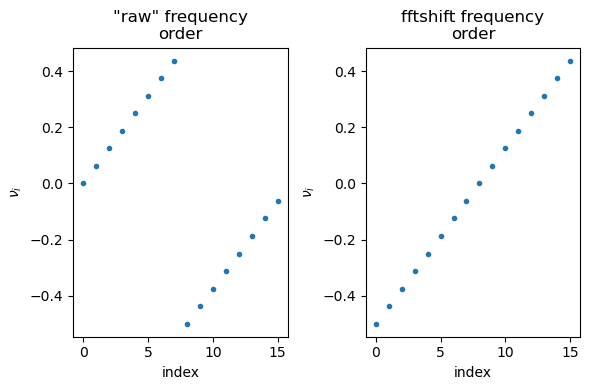

In [5]:
f = fftfreq(16,1)
fig, ax = plt.subplots(1,2)
ax[0].plot(f,'.')
ax[0].set_xlabel('index')
ax[0].set_ylabel(r'$\nu_i$')
ax[0].set_title('"raw" frequency\norder')
f = fftshift(f)
ax[1].plot(f,'.')
ax[1].set_xlabel('index')
ax[1].set_ylabel(r'$\nu_i$')
ax[1].set_title('fftshift frequency\norder')
plt.tight_layout()

If one plots the raw output as a line, one still sees the transform associated with the correct frequencies, but because of the ordering there are spurious lines. `fftshift` fixes this. Plotting the modulus of the complex transform of $\cos(16x)$, we see

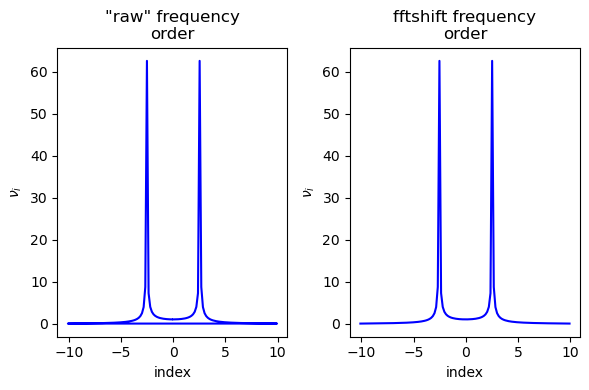

In [7]:
N = 128
x = np.linspace(-np.pi,np.pi,N)
f = np.cos(16*x)
F = fft(f)
nu = fftfreq(N, x[1]-x[0])
fig, ax = plt.subplots(1,2)
ax[0].plot(nu, np.abs(F),'b')
ax[0].set_xlabel('index')
ax[0].set_ylabel(r'$\nu_i$')
ax[0].set_title('"raw" frequency\norder')
# shift frequencies and transform in to ascending frequency order
nu = fftshift(nu)
F = fftshift(F)
ax[1].plot(nu, np.abs(F),'b')
ax[1].set_xlabel('index')
ax[1].set_ylabel(r'$\nu_i$')
ax[1].set_title('fftshift frequency\norder')
plt.tight_layout()

For the remainder of this notebook, we will plot things in shifted order. Note that when you are using FFT's for mathematical purposes like convolution, there is no need to do any shifting; `ifft(fft(f))` still returns `f`.

Note also that scipy's routines don't bother with normalizing the result, leaving it up to you to chose whichever convention you wish (or not to bother).

Let's define some functions to help us play with 1D FFT's:

In [8]:
def gaussian(x, center, sigma):
    sigma /= 2
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp( -0.5*((x-center)/sigma)**2 )

def rect(x, center, width):
    return np.where(((x-center)>-0.5*width) & ((x-center)<0.5*width),1,0)

def delta(center, xmin, xmax, N):
    xgrid = np.linspace(xmin, xmax, N)
    f = np.zeros(N)
    f[center] = 1
    return xgrid, f

def plotreal(ax, x, y):
    """
    For plotting a function in "real" space
    """
    ax.plot(x, y.real, 'g')
    ax.plot(x, y.imag, 'r')

def plotfft(ax, x, y):
    """
    For plotting a function in Fourier space
    """
    ax.plot(x, y.real, 'g')
    ax.plot(x, y.imag, 'r')
    ax.plot(x, np.abs(y), 'b')

def makeFunc(func, center, width, xmin, xmax, N):
    """
    Make a periodic grid populated with function values
    """
    xgrid = np.linspace(xmin, xmax, N)
    length = xmax-xmin
    yfunc = func(xgrid, center, width) +  func(xgrid, center-length, width)
    return xgrid, yfunc

def doplot(xgrid, yfunc):
    N = xgrid.shape[0]
    dx = xgrid[1]-xgrid[0]
    
    f, ax = plt.subplots(3,1, figsize=(5,7))
    plotreal(ax[0], xgrid, yfunc)
    myr = np.max(np.abs(yfunc))
    ax[0].set_xlim(np.min(xgrid)-0.5,np.max(xgrid)+0.5)
    ax[0].set_ylim(-myr-0.5, myr+0.5)
    ax[0].set_xlabel(r'$x$')

    ytwid = fftshift(fft(yfunc))
    kfreq = fftshift(fftfreq(N,dx))
    plotfft(ax[1], kfreq, ytwid)
    ax[1].set_xlim(1.05*kfreq[0], 1.05*kfreq[-1])
    myf = np.max(np.abs(ytwid))
    myf = max( myf, np.max(ytwid.real) )
    myf = max( myf, np.max(ytwid.imag) )
    ax[1].set_ylim(-myf-0.5, myf+0.5)
    ax[1].set_xlabel(r'$\nu$')

    yagain = ifft(ifftshift(ytwid))
    plotreal(ax[2], xgrid, yagain)
    ax[2].set_xlim(np.min(xgrid)-0.5,np.max(xgrid)+0.5)
    ax[2].set_ylim(-myr-0.5, myr+0.5)
    ax[2].set_xlabel(r'$x$')

    plt.tight_layout()

Let's begin with the finite representation of a delta function. In the following plots, the modulus of complex numbers are plotted in blue, the real part in green, and the imaginary part in red.

The Fourier transform of a $\delta$ function at the origin is pure real, with modulus of one:

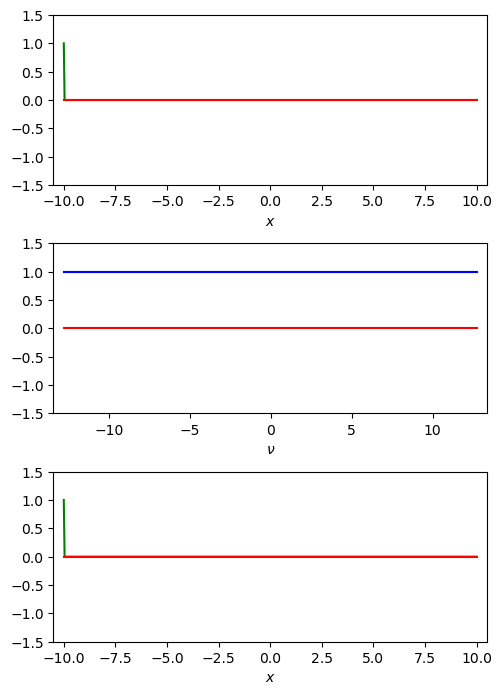

In [9]:
N = 512
xmin = -10
xmax = 10

xgrid, yfunc = delta(0, xmin, xmax, N)

doplot(xgrid, yfunc)

Now let's move the delta function to the right by one gridpoint, so this is $\delta(x-...)$. The modulus is still everywhere one, but its transform is are cosines and sines with wavelengths which just fit into the interval in frequency:

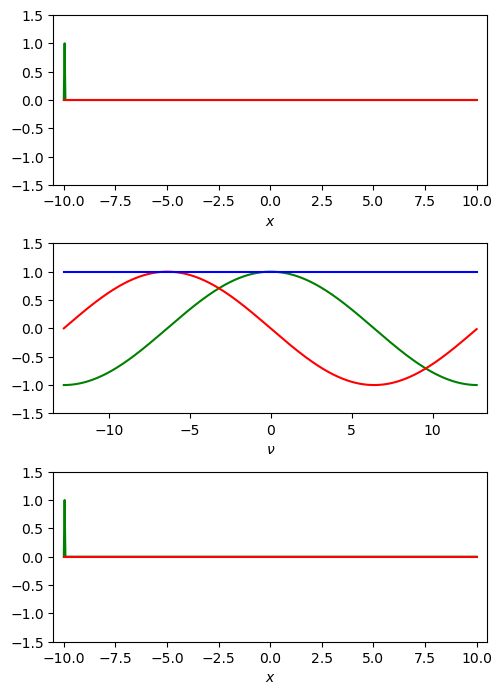

In [10]:
N = 512
xmin = -10
xmax = 10

xgrid, yfunc = delta(1, xmin, xmax, N)

doplot(xgrid, yfunc)

One more "pixel" over, and two wavelengths fit:

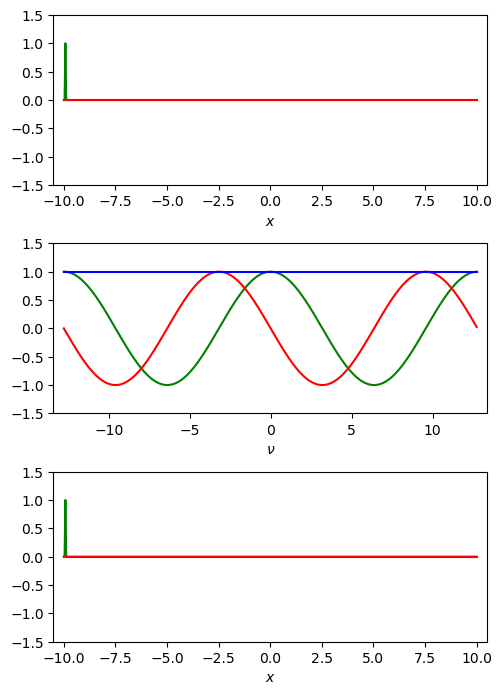

In [11]:
N = 512
xmin = -10
xmax = 10

xgrid, yfunc = delta(2, xmin, xmax, N)

doplot(xgrid, yfunc)

Now put the $\delta$ function in the center of the grid, using a smaller grid size to see more clearly what is going on:

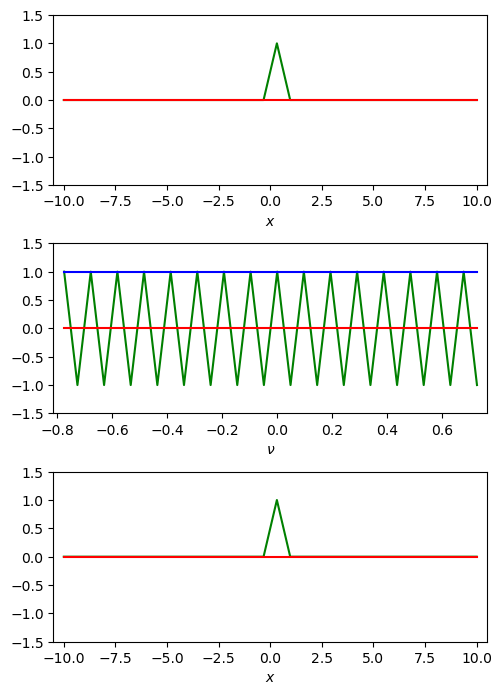

In [12]:
N = 32
xmin = -10
xmax = 10

xgrid, yfunc = delta(N//2, xmin, xmax, N)

doplot(xgrid, yfunc)

And finally, move it one point to the right of center:

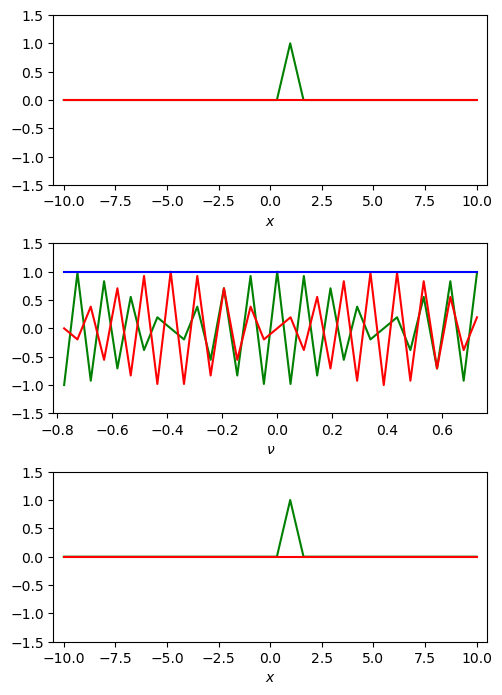

In [13]:
N = 32
xmin = -10
xmax = 10

xgrid, yfunc = delta(N//2+1, xmin, xmax, N)

doplot(xgrid, yfunc)

Let's now do the same thing with a Gaussian of width $\sigma=0.25$, with the Gaussian centered about 10
on our periodic grid; the Fourier transform of a Gaussian is a Gaussian:

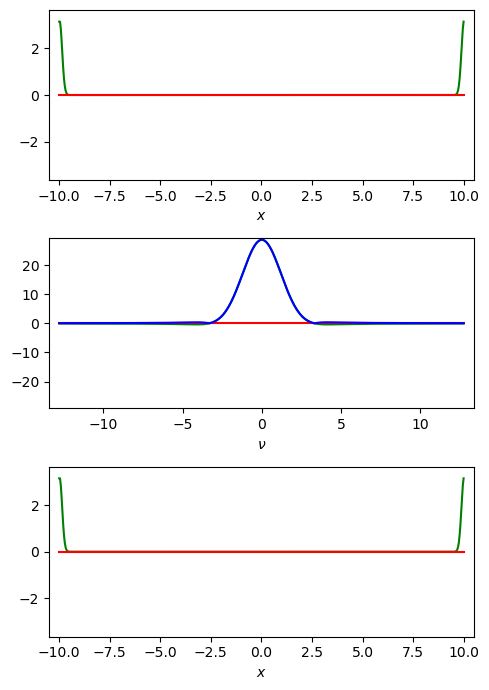

In [14]:
N = 512
xmin = -10
xmax = 10
dx = (xmax-xmin)/(N-1)
center = 10 + dx/2  # exactly centered -- zero imaginary part in FFT

width = 0.25

xgrid, yfunc = makeFunc(gaussian, center, width, xmin, xmax, N)

doplot(xgrid, yfunc)

Now move the mean to -8.5; the shift is encoded in the real and imaginary parts; the modulus is still the same
Gaussian:

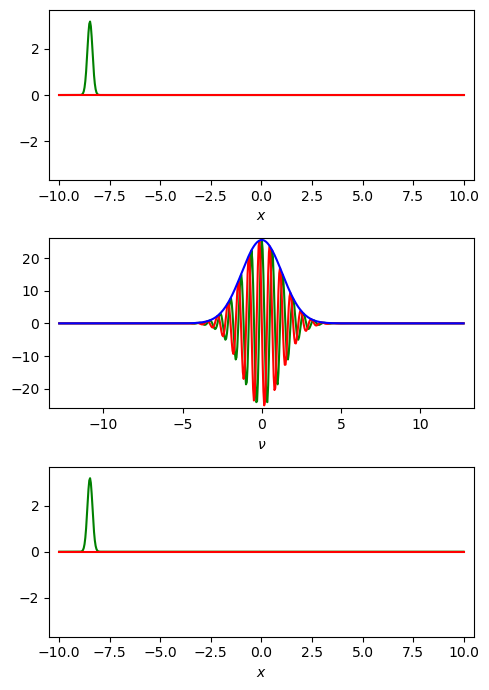

In [15]:
N = 512
xmin = -10
xmax = 10
dx = (xmax-xmin)/(N-1)
center = -8.5 + dx/2  # exactly centered -- zero imaginary part in FFT

width = .25

xgrid, yfunc = makeFunc(gaussian, center, width, xmin, xmax, N)

doplot(xgrid, yfunc)

Try a square pulse... what is the 2D version of this known as in optics?

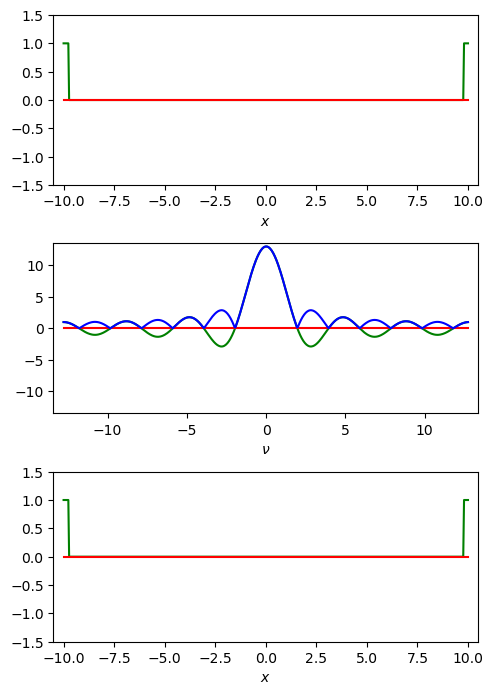

In [16]:
N = 512
xmin = -10
xmax = 10
dx = (xmax-xmin)/(N-1)
center = 10 + dx/2  # exactly centered -- zero imaginary part in FFT
#center = 5 + dx/2  # not centered -- oscillatory imaginary part in FFT
width = .5
xgrid, yfunc = makeFunc(rect, center, width, xmin, xmax, N)
doplot(xgrid, yfunc)

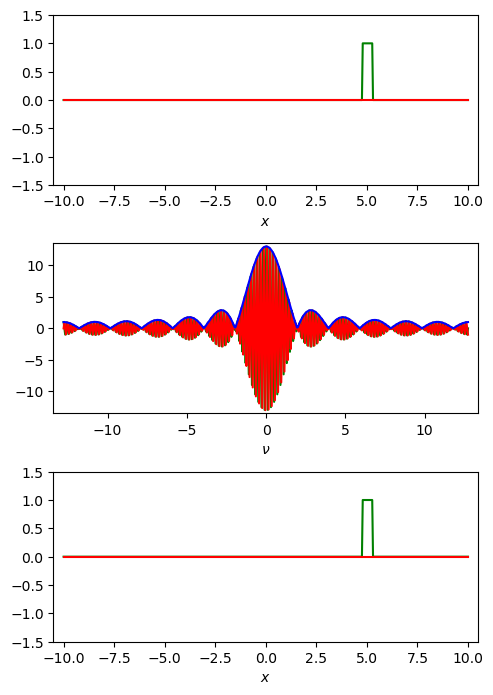

In [17]:
N = 512
xmin = -10
xmax = 10
dx = (xmax-xmin)/(N-1)
#center = 10 + dx/2  # exactly centered -- zero imaginary part in FFT
center = 5 + dx/2  # not centered -- oscillatory imaginary part in FFT
width = .5
xgrid, yfunc = makeFunc(rect, center, width, xmin, xmax, N)
doplot(xgrid, yfunc)

Now try some signal processing. We start with the function $f(x) = \cos(25 (2\pi x)) + \sin(5 (2\pi x))$.
Remember that $\sin$ and $\cos$ have two components each in their transforms.

We then create a function which is one for $|\nu| < 10$ and zero outside, and multiply $\mathcal{F}(f)$ by it to remove the power at higher frequencies, and inverse transform the result. This is known as a low-pass filter (not a very good one!).

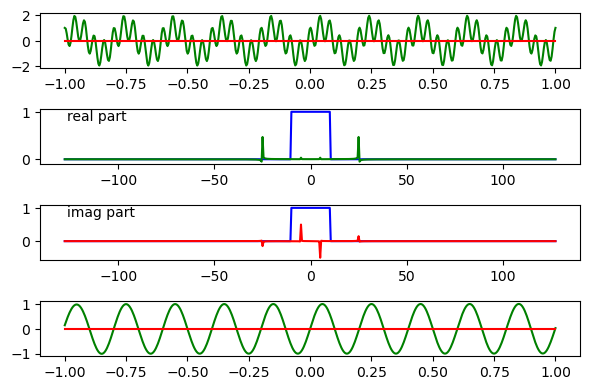

In [18]:
f, ax = plt.subplots(4,1)

N = 512
xmin = -1
xmax = 1

xgrid = np.linspace(xmin, xmax, num=N)
dx = xgrid[1]-xgrid[0]

# sample a function in real space
nu1 = 25
nu2 = 5
#yfunc1 = np.exp(2*np.pi*1j*xgrid*nu1)
#yfunc2 = np.exp(2*np.pi*1j*xgrid*nu2)
yfunc1 = np.cos(2*np.pi*xgrid*nu1)
yfunc2 = np.sin(2*np.pi*xgrid*nu2)
yfunc = yfunc1 + yfunc2

plotreal(ax[0], xgrid, yfunc)

kfreq = fftshift(fftfreq(N,dx))
ytwid = fftshift(fft(yfunc))/N

# make a lowpass filter
lowpass = np.where(np.abs(kfreq) < 10, 1, 0)

# plot the filter in blue
ax[1].plot(kfreq, lowpass,'b')
ax[2].plot(kfreq, lowpass,'b')

# plot it in Fourier space
ax[1].plot(kfreq,ytwid.real,'g')
ax[1].text(0.05,0.8,"real part",transform = ax[1].transAxes)
ax[2].plot(kfreq,ytwid.imag,'r')
ax[2].text(0.05,0.8,"imag part",transform = ax[2].transAxes)

ytwid = ytwid*lowpass
yback = ifft(ifftshift(ytwid))*N

# and plot the result
ax[3].plot(xgrid,yback.real,'g')
ax[3].plot(xgrid,yback.imag,'r')

plt.tight_layout()

Replacing the trig functions with exponentials, we see that each exponential has only one component:

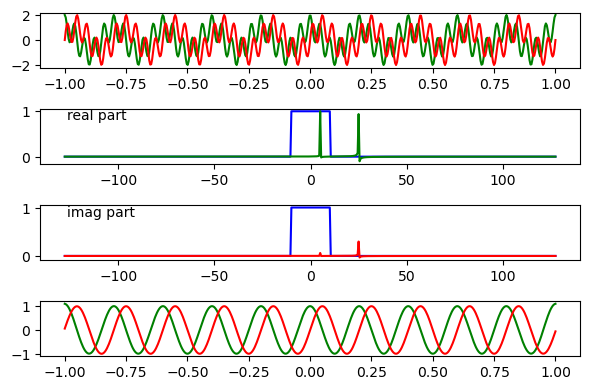

In [19]:
f, ax = plt.subplots(4,1)

N = 512
xmin = -1
xmax = 1

xgrid = np.linspace(xmin, xmax, num=N)
dx = xgrid[1]-xgrid[0]

# sample a function in real space
nu1 = 25
nu2 = 5
yfunc1 = np.exp(2j*np.pi*xgrid*nu1)
yfunc2 = np.exp(2j*np.pi*xgrid*nu2)
#yfunc1 = np.cos(2*np.pi*xgrid*nu1)
#yfunc2 = np.sin(2*np.pi*xgrid*nu2)
yfunc = yfunc1 + yfunc2

plotreal(ax[0], xgrid, yfunc)

kfreq = fftshift(fftfreq(N,dx))
ytwid = fftshift(fft(yfunc))/N

# make a lowpass filter
lowpass = np.where(np.abs(kfreq) < 10, 1, 0)

# plot the filter in blue
ax[1].plot(kfreq, lowpass,'b')
ax[2].plot(kfreq, lowpass,'b')

# plot it in Fourier space
ax[1].plot(kfreq,ytwid.real,'g')
ax[1].text(0.05,0.8,"real part",transform = ax[1].transAxes)
ax[2].plot(kfreq,ytwid.imag,'r')
ax[2].text(0.05,0.8,"imag part",transform = ax[2].transAxes)

ytwid = ytwid*lowpass
yback = ifft(ifftshift(ytwid))*N

# and plot the result
ax[3].plot(xgrid,yback.real,'g')
ax[3].plot(xgrid,yback.imag,'r')

plt.tight_layout()

If we add a frequency to the signal which is outside the bandwidth, its power is aliased into the bandwidth:

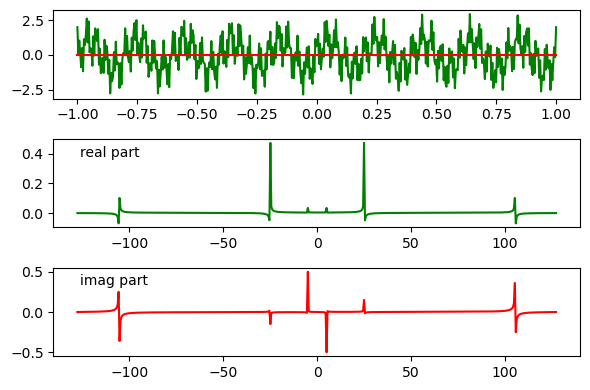

In [20]:
fig, ax = plt.subplots(3,1)

N = 512
xmin = -1
xmax = 1

xgrid = np.linspace(xmin, xmax, num=N)
dx = xgrid[1]-xgrid[0]

# sample a function in real space
nu1 = 25
nu2 = 5
nu3 = 150
#yfunc1 = np.exp(2*np.pi*1j*xgrid*nu1)
#yfunc2 = np.exp(2*np.pi*1j*xgrid*nu2)
yfunc1 = np.cos(2*np.pi*xgrid*nu1)
yfunc2 = np.sin(2*np.pi*xgrid*nu2)
yfunc3 = np.cos(2*np.pi*xgrid*nu3)
yfunc = yfunc1 + yfunc2 + yfunc3

plotreal(ax[0], xgrid, yfunc)

kfreq = fftshift(fftfreq(N,dx))
ytwid = fftshift(fft(yfunc))/N

# plot it in Fourier space
ax[1].plot(kfreq,ytwid.real,'g')
ax[1].text(0.05,0.8,"real part",transform = ax[1].transAxes)
ax[2].plot(kfreq,ytwid.imag,'r')
ax[2].text(0.05,0.8,"imag part",transform = ax[2].transAxes)

plt.tight_layout()

Lets try an even higher frequency; its alias moves even further into the spectrum

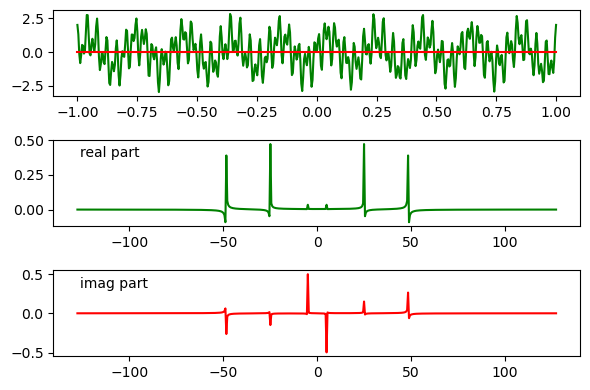

In [21]:
fig, ax = plt.subplots(3,1)

N = 512
xmin = -1
xmax = 1

xgrid = np.linspace(xmin, xmax, num=N)
dx = xgrid[1]-xgrid[0]

# sample a function in real space
nu1 = 25
nu2 = 5
nu3 = 207
#yfunc1 = np.exp(2*np.pi*1j*xgrid*nu1)
#yfunc2 = np.exp(2*np.pi*1j*xgrid*nu2)
yfunc1 = np.cos(2*np.pi*xgrid*nu1)
yfunc2 = np.sin(2*np.pi*xgrid*nu2)
yfunc3 = np.cos(2*np.pi*xgrid*nu3)
yfunc = yfunc1 + yfunc2 + yfunc3

plotreal(ax[0], xgrid, yfunc)

kfreq = fftshift(fftfreq(N,dx))
ytwid = fftshift(fft(yfunc))/N

# plot it in Fourier space
ax[1].plot(kfreq,ytwid.real,'g')
ax[1].text(0.05,0.8,"real part",transform = ax[1].transAxes)
ax[2].plot(kfreq,ytwid.imag,'r')
ax[2].text(0.05,0.8,"imag part",transform = ax[2].transAxes)

plt.tight_layout()

***

All of this carries over to multiple dimensions. First some convenience functions for 2D FFTs which preserve the total power; we didn't bother to include the factors of $N$ in the examples above. We also define some plotting functions for images.

In [22]:
# my N-dimensional FFT utility
def myfft(func):
    return fftshift(fftn(func))/func.size

# my N-dimensional iFFT utility
def myifft(func):
    return np.abs( ifftn(ifftshift(func))*func.size )

def implotreal(img, lab):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=cm.Greys_r)
    print(f"{lab:20s}   min:{img.min():9.4e}  max:{img.max():9.4e}  sum:{img.sum():9.4e}")
    
def implotcmplx(img, lab):
    fig, ax = plt.subplots()
    ax.imshow(np.log10(np.abs(img)+1e-10), cmap=cm.Greys_r)
    print(f"{lab:20s}   min:{img.min():9.4e}  max:{img.max():9.4e}  sum:{img.sum():9.4e}")

and a function to create a 2D Gaussian:

In [23]:
def gaussArray(shape, center, sigma):
    filter = np.zeros(shape)
    x, y = np.mgrid[0:shape[0], 0:shape[1]]
    g = 1/(2*np.pi*sigma**2)*np.exp( -((x-shape[0]//2)**2+(y-shape[1]//2)**2)/(2*sigma**2) )
    return np.roll(g, center, axis=(0,1))    # shift to desired center

Create a 2D gaussian at the center of a square array:

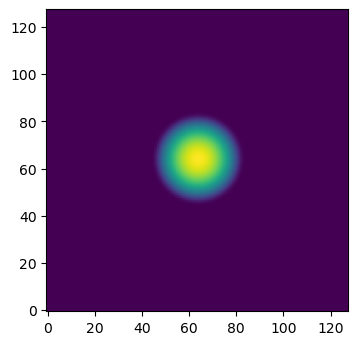

In [24]:
N = 128
g = gaussArray((N,N), (0,0), 3)
fig, ax = plt.subplots()
ax.imshow(np.log10(g.T+1.0e-10), cmap=cm.viridis, origin='lower');

Here is the Fourier transform, with cuts through the center in the x- and y-directions:

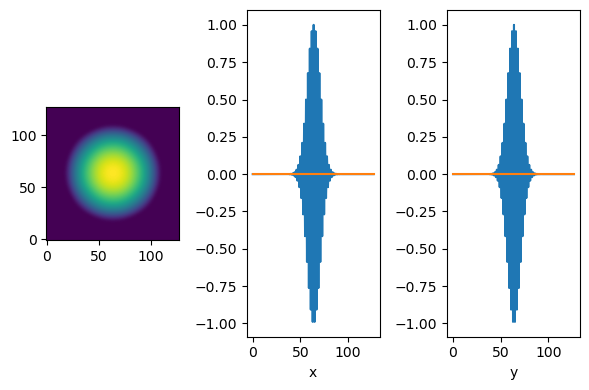

In [25]:
G = fftshift(fftn(g))
fig, ax = plt.subplots(1,3)
q = np.log(np.abs(G)+1e-10)
ax[0].imshow(q.T, cmap=cm.viridis, origin='lower')
ax[1].plot(np.arange(N), G[:,N//2].real)
ax[1].plot(np.arange(N), G[:,N//2].imag)
ax[1].set_xlabel('x')
ax[2].plot(np.arange(N), G[N//2,:].real)
ax[2].plot(np.arange(N), G[N//2,:].imag)
ax[2].set_xlabel('y')
plt.tight_layout()

We now shift the Gaussian to the beginning/ending of the grid:

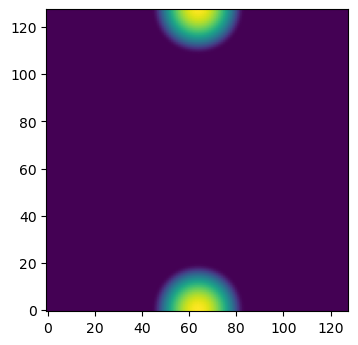

In [26]:
N = 128
g = gaussArray((N,N), (0,N//2), 3)
fig, ax = plt.subplots()
ax.imshow(np.log10(g.T+1.0e-10), cmap=cm.viridis, origin='lower')

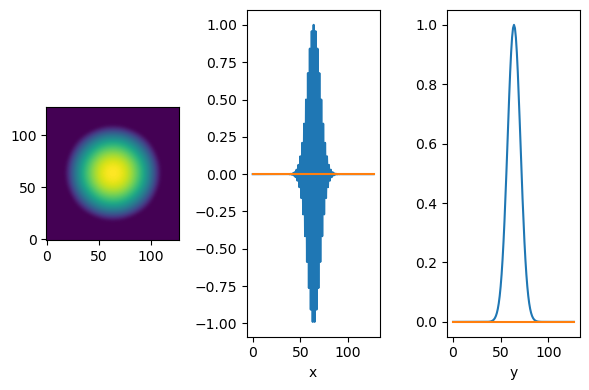

In [27]:
G = fftshift(fftn(g))
fig, ax = plt.subplots(1,3)
q = np.log(np.abs(G)+1e-10)
ax[0].imshow(q.T, cmap=cm.viridis, origin='lower')
ax[1].plot(np.arange(N), G[:,N//2].real)
ax[1].plot(np.arange(N), G[:,N//2].imag)
ax[1].set_xlabel('x')
ax[2].plot(np.arange(N), G[N//2,:].real)
ax[2].plot(np.arange(N), G[N//2,:].imag)
ax[2].set_xlabel('y')
plt.tight_layout()

***

Now let's try some practical examples from image processing. Here is a function to put pixels on $[0,1]$:

In [28]:
def normalize(image):
    """
    Put image pixels on [0,1]
    """
    image -= image.min()
    image /= image.max()
    return image

Read in a random image and display it; note that the rows of png images (and most other image formats) are numbered like the rows of a matrix: 

original image         min:0.0000e+00  max:1.0000e+00  sum:1.2010e+05


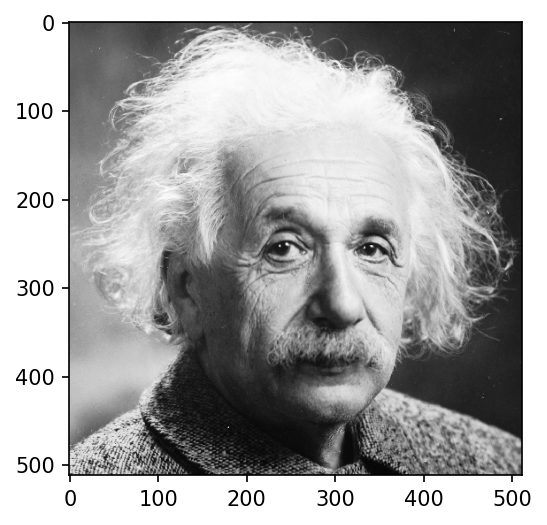

In [29]:
plt.rcParams['figure.dpi'] = 150
orig = imread('einstein512.png', as_gray=True)
orig = normalize(orig)
implotreal(orig, "original image")

Take it's Fourier transform. The transform is symmetric about the center because the image has no complex part. The white dot at the center is the DC value -- the sum of all pixels in the image.

forig                  min:-4.7435e-02-7.0063e-02j  max:4.5814e-01-0.0000e+00j  sum:2.6613e-01+0.0000e+00j


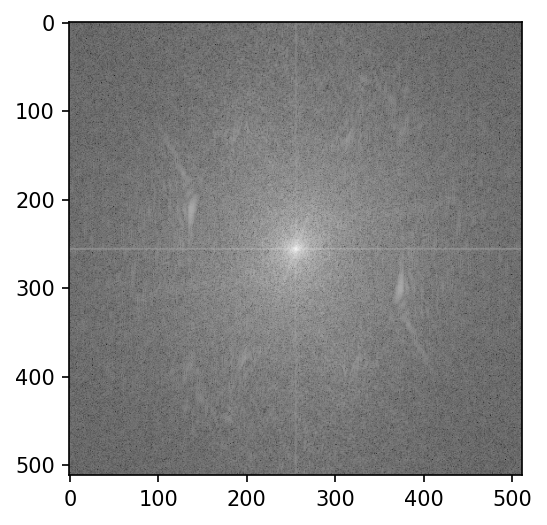

In [30]:
forig = myfft(orig)
implotcmplx(forig, "forig")

Create Gaussian filter with $\sigma = 3$ pixels. This is just the transform of a Gaussian with $\sigma=3$

fblur                  min:-9.8922e-01-2.5153e-17j  max:1.0000e+00-0.0000e+00j  sum:-1.5987e-14-4.9304e-31j


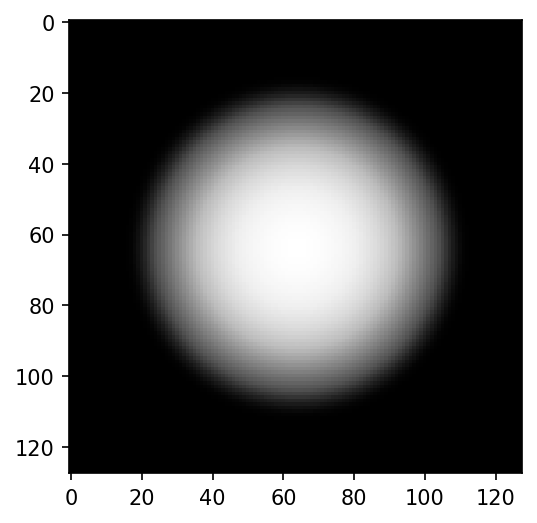

In [31]:
N = orig.shape[0]
g = gaussArray((N,N), (0,0), 3)
fblur = myfft(g)
implotcmplx(G, "fblur")

Convolve the filter with the image by multiplication in Fourier space; the high frequency components are
suppressed smoothly. What would one get if one just used a sharp curoff in radius?

fprod                  min:-1.4787e-07-9.0688e-08j  max:1.7477e-06-0.0000e+00j  sum:2.0772e-06-9.8092e-23j


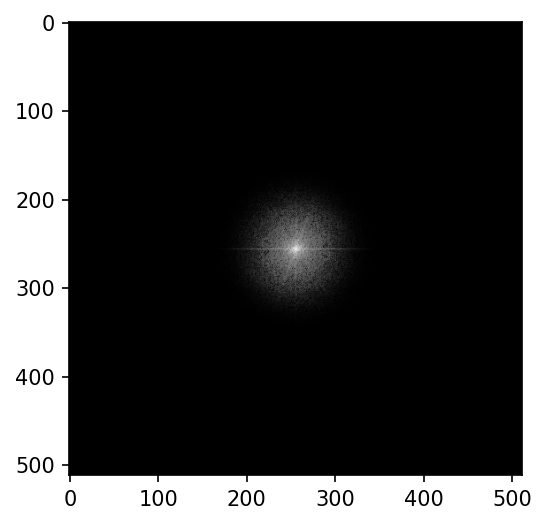

In [32]:
fprod = fblur*forig
implotcmplx(fprod, "fprod")

When we go back into real space, we see the convolution of the gaussian and the image -- a blurred picture of Einsten. Wait, what went wrong?

result                 min:1.1944e-07  max:3.7112e-06  sum:4.5814e-01


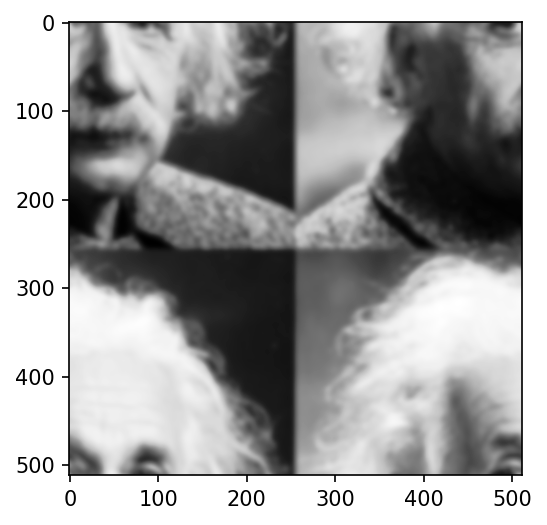

In [33]:
result = myifft(fprod).real
implotreal(result,"result")

We didn't center our Gaussian filter on the origin, and the resulting image was shifted. Indeed, shifting images, especially by fractional pixels, is best done with Fourier techniques (essentially, convolution with a $\delta$ function).

Let's create a better filter:

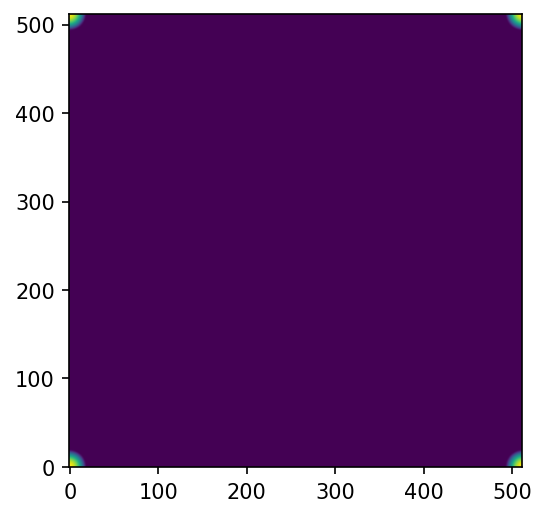

In [34]:
g = gaussArray((N,N), (N//2,N//2), 3)
fig, ax = plt.subplots()
ax.imshow(np.log10(g.T+1.0e-10), cmap=cm.viridis, origin='lower')

fblur                  min:-9.8922e-01-2.5153e-17j  max:1.0000e+00-0.0000e+00j  sum:-1.5987e-14-4.9304e-31j


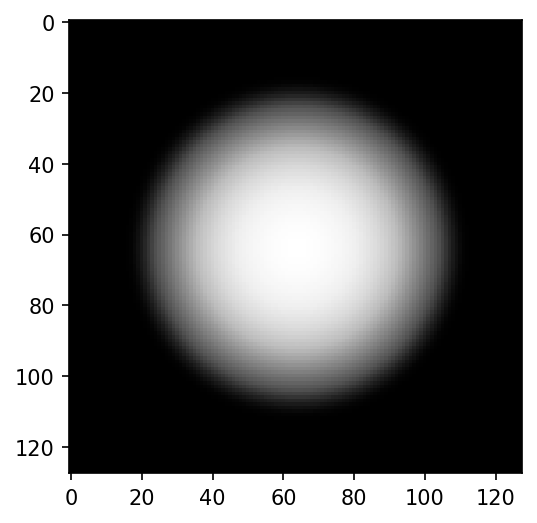

In [35]:
fblur = myfft(g)
implotcmplx(G, "fblur")

Redo the convolution

fprod                  min:-1.8083e-07-2.6709e-07j  max:1.7477e-06-0.0000e+00j  sum:1.1655e-06-3.5507e-22j


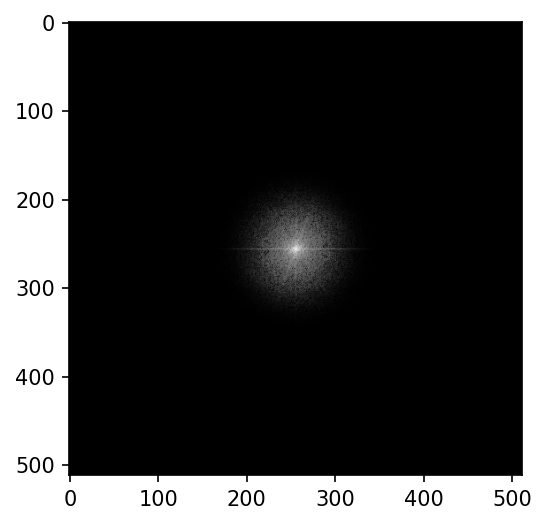

In [36]:
fprod = fblur*forig
implotcmplx(fprod, "fprod")

This time the result is what we intended!

result                 min:1.1944e-07  max:3.7112e-06  sum:4.5814e-01


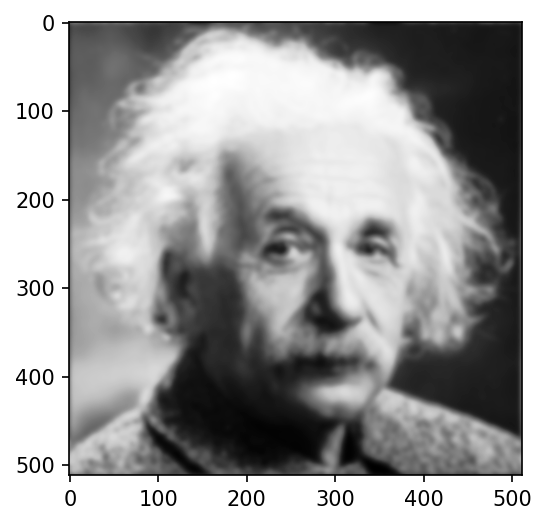

In [37]:
# Gaussina blurred

blurred = myifft(fprod).real
implotreal(blurred,"result")

We can codify this procedure into a function to blur an image with a given sigma in pixels

In [38]:
def gaussArray(shape, center, sigma):
    filter = np.zeros(shape)
    x, y = np.mgrid[0:shape[0], 0:shape[1]]
    g = 1/(2*np.pi*sigma**2)*np.exp( -((x-shape[0]//2)**2+(y-shape[1]//2)**2)/(2*sigma**2) )
    return np.roll(g, center, axis=(0,1))    # shift to desired center

def gaussianFilter(shape, sigma):
    g = gaussArray(shape, (shape[0]//2,shape[1]//2), sigma)
    fblur = np.abs( myfft(g) ) * g.size
    return fblur

def gaussianBlur(orig, sigma):
    fblur = gaussianFilter(orig.shape, sigma)
    forig = myfft(orig)
    conv = fblur*forig
    return myifft(conv).real

def fgaussianBlur(orig, sigma):
    fblur = gaussianFilter(orig.shape, sigma)
    forig = myfft(orig)
    fprod = fblur*forig
    return fprod

result                 min:3.1312e-02  max:9.7288e-01  sum:1.2010e+05


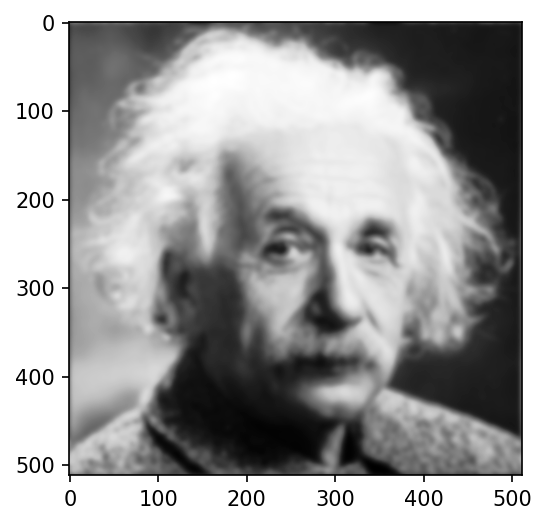

In [39]:
blurred = gaussianBlur(orig, 3)
implotreal(blurred.real,"result")

***
#### Edge Detection

The following matrices are designed to enhance edges when convolved with an image; they are related to the finite difference representaion of a gradient:

In [40]:
def scharrX(shape):
    """
    Scharr x-gradient filter
    """
    filter = np.zeros(shape)

    filter[0:3,0:3] = np.array([ [ 1, 0, -1],
                                 [ 3, 0, -3],
                                 [ 1, 0, -1] ])

    filter =  fftn(filter)
    return filter

def scharrY(shape):
    """
    Scharr y-gradient filter
    """
    filter = np.zeros(shape)

    filter[0:3,0:3] = np.array([ [ 1, 0, -1],
                                 [ 3, 0, -3],
                                 [ 1, 0, -1] ]).T

    filter =  fftn(filter)
    return filter

Read in a different sample image

original               min:0.0000e+00  max:1.0000e+00  sum:2.1643e+05


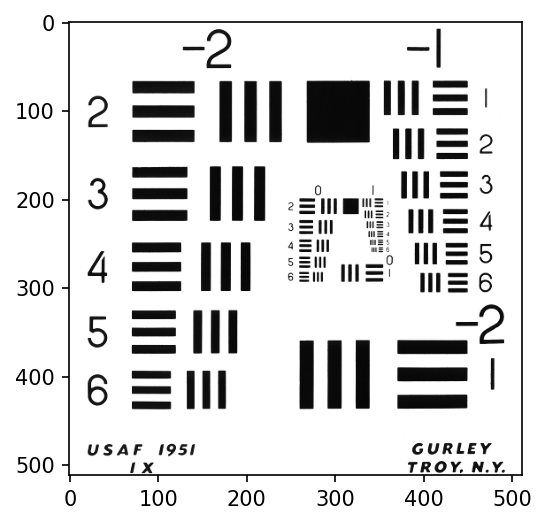

In [41]:
orig = imread('USAF512.png', as_gray=True)
orig = normalize(orig)
implotreal(orig, "original")

We reduce the effects of noise in the image by operating on a blurred image.

We then convolve the filters with the image to get the x- and y-gradient images

In [42]:
# FFT of blurred image
fblur = fgaussianBlur(orig, 1)

# get Scharr filters
xfilter = scharrX(orig.shape)
yfilter = scharrY(orig.shape)

# convolve!
# take real part, not modulus, since we care about the sign
gradx = myifft(fblur*xfilter).real
grady = myifft(fblur*yfilter).real

Compare the original image (center) with the x-gradient one (left) and the y-gradient one (right)

4.2452242731990004e-05


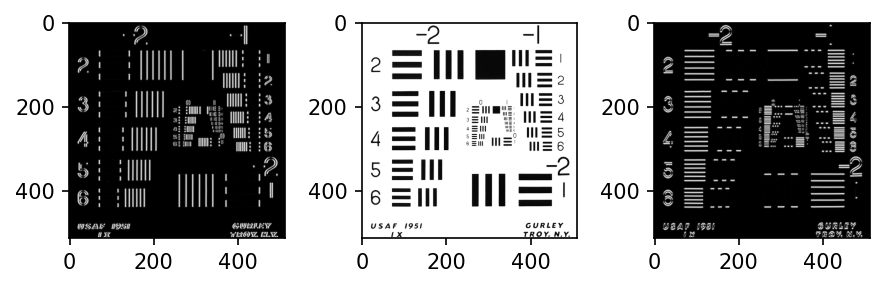

In [43]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(gradx, cmap=cm.Greys_r)
ax[1].imshow(orig, cmap=cm.Greys_r)
ax[2].imshow(grady, cmap=cm.Greys_r);
plt.tight_layout()
print(gradx[0,0])

Clamp noise near zero:

In [44]:
gradx[np.fabs(gradx)<0.25] = 0
grady[np.fabs(grady)<0.25] = 0

Get magnitude of the image gradient -- find edges

|gradient|             min:0.0000e+00  max:9.4341e-01  sum:1.9483e+04


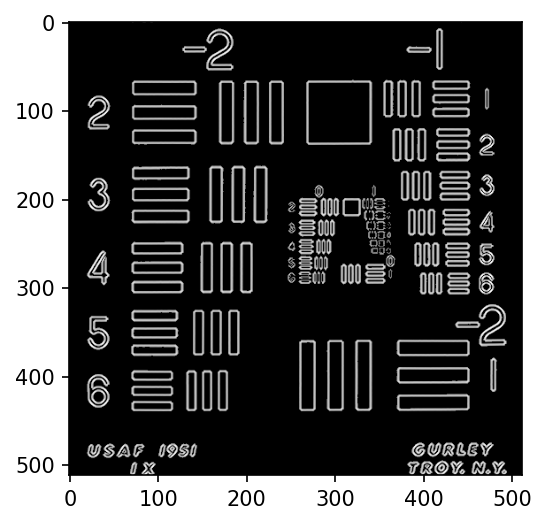

In [45]:
grad = np.sqrt( gradx**2 + grady**2 )
implotreal(grad, '|gradient|')

Get direction of the image gradient on $[0,\pi/2]$

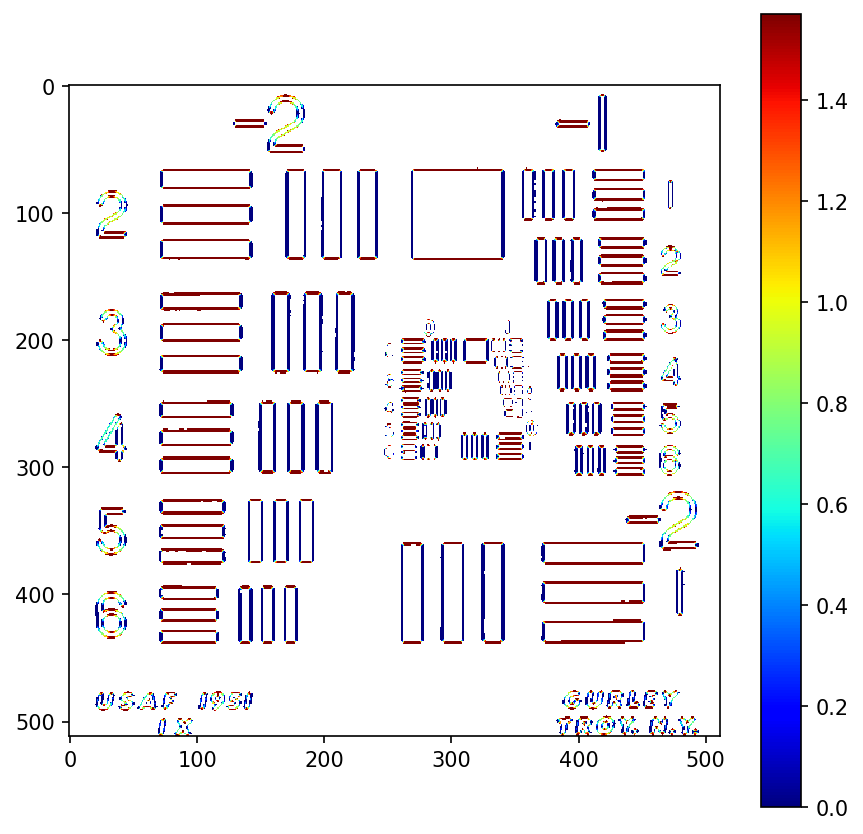

In [46]:
direction = np.arctan2(grady, gradx)
# where the gradient is zero, flag with illegal value so it won't plot
direction[(grad==0)] = np.nan
fig,ax = plt.subplots(figsize=(7,7))
im = ax.imshow(direction, cmap=cm.jet)
fig.colorbar(im);

***

Histogram equization is a way to spread the pixel values most uniformly over an image, increasing its contrast. We'll use this below.

In [47]:
def histeq(image):
    """
    Histogram equilaization of image
    """
    # create a histogram of pixel values
    shape = image.shape
    image = np.floor(255*normalize(image))
    h, bins = np.histogram(image.flatten(), bins=256)
    # the cumulative histogram
    c = np.cumsum(h)/image.size
    # the equilized image
    eqim = c[np.floor(image.flatten()).astype(np.int32)].reshape(shape)
    return eqim

Now let's try *unsharp masking*, a feature of every cell phone's camera system and often abused by amateur photographers!

We use our blurred image -- an image with less power at high spatial frequencies. 

By subtracting this from the original image, we get an image which has most of its power at high spatial frequencies:

orig-blurred           min:-5.4177e-01  max:7.2358e-01  sum:-1.0528e-03


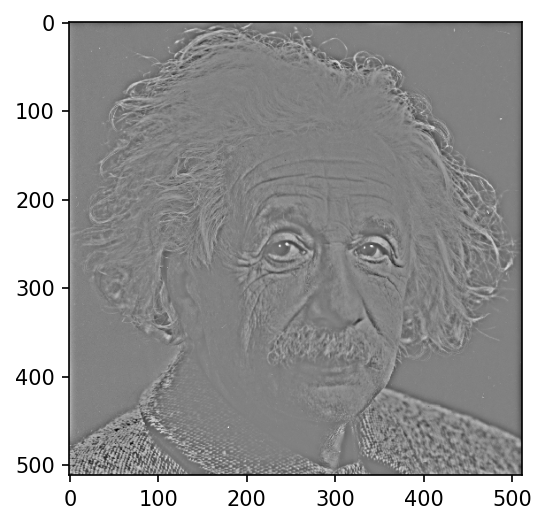

In [48]:
orig = imread('einstein512.png', as_gray=True)
orig = normalize(orig)
blurred = gaussianBlur(orig, 4)
implotreal(orig-blurred, "orig-blurred") # high-freq information only

We can add some of this back into the original, to boost its power at high spatial frequencies. This is unsharp masking. It looks a bit as if we had more resolution than in the original image, but of course this is only an illusion...

In [49]:
eps = 0.9
sharpened = orig + eps*(orig-blurred)
sharpened = histeq(sharpened)
orig = histeq(orig)

The results: unsharp masked on the left, the original on the right

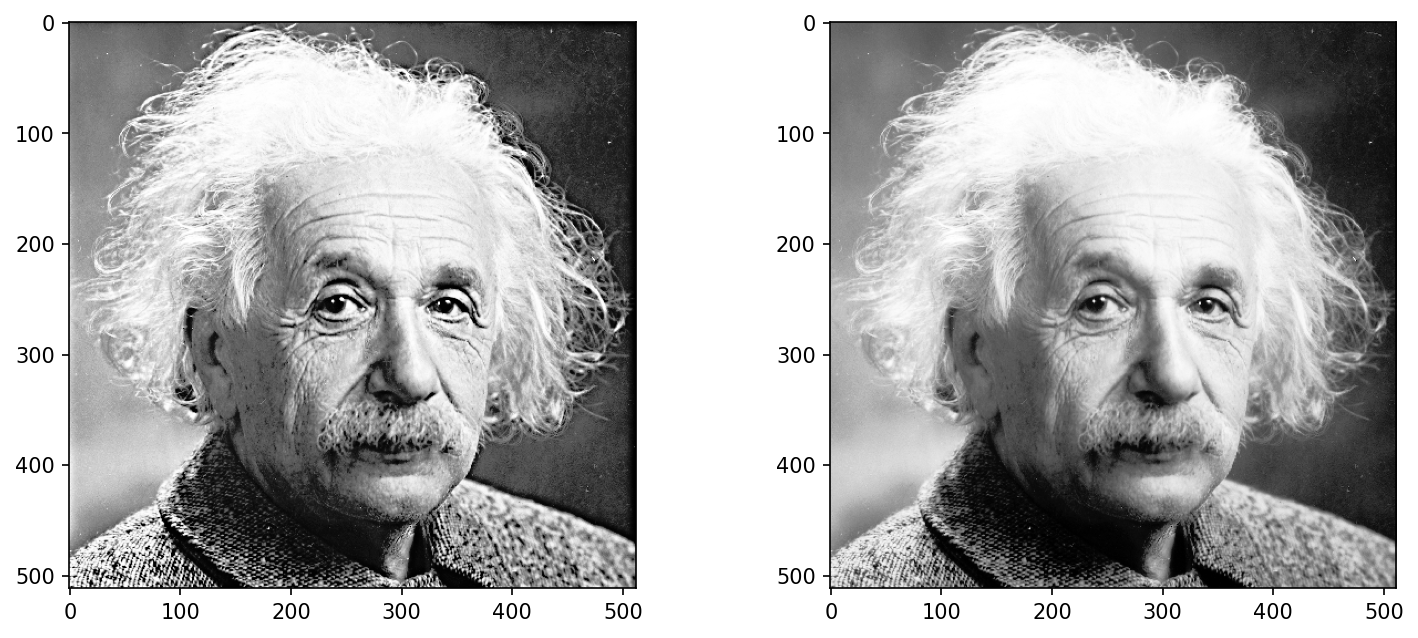

In [50]:
fig,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(sharpened, cmap=cm.Greys_r)
ax[1].imshow(orig, cmap=cm.Greys_r);